# Example Magritte script for processing MCP input.
---

In [1]:
import sys
magritteFolder = '/home/frederik/Dropbox/GitHub/Magritte/'
sys.path.append(magritteFolder)

datdir = f'{magritteFolder}/tests/data/'
moddir = f'{magritteFolder}/tests/models/'
resdir = f'{magritteFolder}/tests/results/'

import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import magritte.tools    as tools
import magritte.setup    as setup
import magritte.core     as magritte

from astropy    import constants, units
from ipywidgets import interact

# Path to MCP input file
mcp_file = '/home/frederik/IvS/Sofia/IRAS_22035-MCPinput.txt'

# Load the MCP input file
(Rs, T, nH2, X, Vr, Vt) = np.loadtxt(mcp_file, skiprows=15, unpack=True, usecols=[1,2,4,5,6,7])

# Convert units to SI (where necessary)
Rs  *= 1.0e-2   # convert cm   to m
nH2 *= 1.0e+6   # convert cm-3 to m-3
Vr  *= 1.0e+3   # convert km/s to m/s
Vt  *= 1.0e+3   # convert km/s to m/s

# Convert velocities to fractions of the speed of light
Vr /= constants.c.si.value
Vt /= constants.c.si.value

# Define model file and line data file
modelFile = f'{moddir}/example_mcp.hdf5'
lamdaFile = f'{datdir}/co.txt'

# Define model parameters
dimension = 1         # effective spatial dimension (1 for spherical symmetry)
npoints   = len(Rs)   # number of spatial points
nrays     = 100       # number of rays to trace from each point
nspecs    = 5         # number of chemical species (minimum 5)
nlspecs   = 1         # number of chemical species we consider in line RT
nquads    = 5        # number of roots/weights to use in Gauss-Hermite quadrature


def create_model():
    # Setup magritte model
    model = magritte.Model ()
    model.parameters.set_model_name         (modelFile)
    model.parameters.set_dimension          (dimension)
    model.parameters.set_spherical_symmetry (True)
    model.parameters.set_npoints            (npoints)
    model.parameters.set_nrays              (nrays)
    model.parameters.set_nspecs             (nspecs)
    model.parameters.set_nlspecs            (nlspecs)
    model.parameters.set_nquads             (nquads)
    model.parameters.set_pop_prec           (1.0e-6)

    model.geometry.points.position.set([[r, 0, 0] for r in Rs])
    model.geometry.points.velocity.set([[v, 0, 0] for v in Vr])

    model.chemistry.species.symbol    =  ['dummy0', 'CO', 'H2', 'e-', 'dummy1']
    model.chemistry.species.abundance = [[     0.0, x*h2,   h2,  0.0,      1.0] for (x,h2) in zip(X,nH2)]

    model.thermodynamics.temperature.gas  .set(T    )
    model.thermodynamics.turbulence.vturb2.set(Vt**2)

    model = setup.set_Delaunay_neighbor_lists  (model)
    model = setup.set_Delaunay_boundary        (model)
    model = setup.set_boundary_condition_CMB   (model)
    model = setup.set_rays_spherical_symmetry  (model)
    model = setup.set_linedata_from_LAMDA_file (model, lamdaFile)
    model = setup.set_quadrature               (model)

    model.write()

In [2]:
# Create magritte model
create_model()

# Load magritte model
model = magritte.Model (modelFile)

model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

# model.compute_level_populations (True, 100)

0

In [3]:
npoints = model.parameters.npoints()
nfreqs  = model.parameters.nfreqs()
nrays   = model.parameters.nrays()
hnrays  = model.parameters.hnrays()

rs      = np.array(model.geometry.points.position   )[:, 0]
ns      = np.array(model.chemistry.species.abundance)[:, 1]

nlev    = model.lines.lineProducingSpecies[0].linedata.nlev
pops    = model.lines.lineProducingSpecies[0].population.reshape((npoints,nlev))

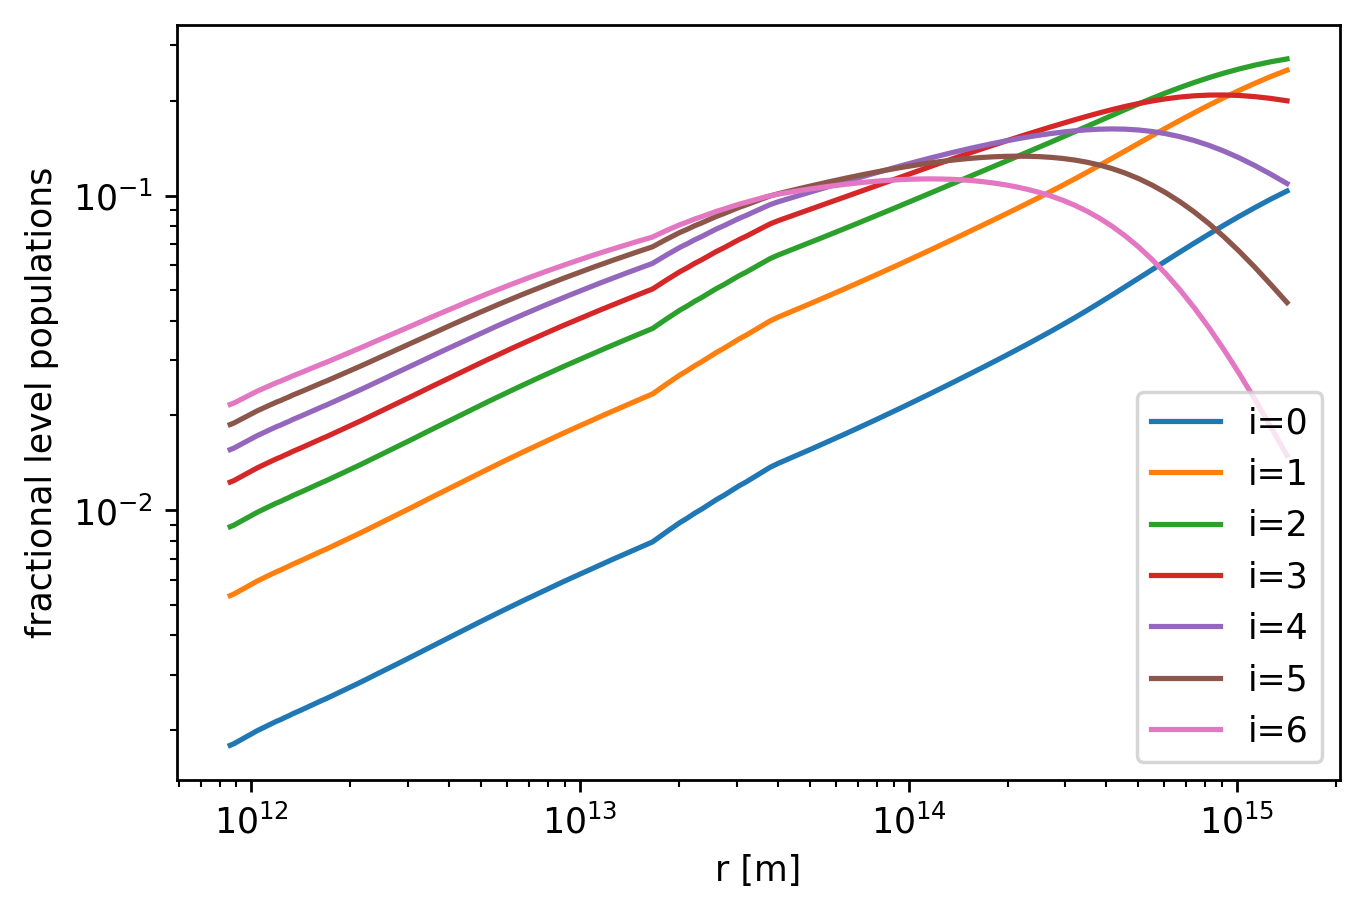

In [4]:
# Plot level populations
plt.figure(dpi=250)
for i in range(7):
    plt.plot(rs, pops[:,i]/ns, label=f'i={i}')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('fractional level populations')
plt.xlabel('r [m]')
plt.legend()

In [5]:
# Define range to make spectrum
fcen = model.lines.lineProducingSpecies[0].linedata.frequency[1]
dvel = 1.5e+4   # [m/s]
fmin = fcen*(1.0 - dvel/magritte.CC)
fmax = fcen*(1.0 + dvel/magritte.CC)

model.compute_spectral_discretisation (fmin, fmax)
model.compute_image (hnrays-1)

fs = np.array(model.radiation.frequencies.nu)[0]
r  = np.array(model.images[-1].ImX)
I  = np.array(model.images[-1].I)

# Subtract background (CMB)
I = np.array([ii-tools.I_CMB(fs) for ii in I])

In [6]:
# Integrated intensity over a solid disk

distance = (230 * units.pc).si.value

I_int = [0]
for p in range(1, npoints):
    two_pi_r_dr = 2.0*np.pi * 0.5*(r[p] + r[p-1]) * (r[p] - r[p-1])
    # Integrate over circle
    ii = I_int[-1] + two_pi_r_dr * 0.5*(I[p] + I[p-1])
    I_int.append(ii)
I_int = I_int[1:]
# Rescale for distance
I_int /= distance**2
# Convert to Jansky
I_int /= 1.0e-26

In [12]:
velo = (1.0 - fs/fcen)*magritte.CC * 1.0e-3

def plot(p):    
    plt.figure(dpi=150)
    plt.plot(velo, I_int[p])
    plt.xlabel('velocity [km/s]')
    plt.ylabel('flux [Jy]')
    plt.title(f'aperture = {r[p]/(1.0*units.au).si.value:.0f} au')
    plt.show()
interact(plot, p=(0, npoints-2))

interactive(children=(IntSlider(value=73, description='p', max=146), Output()), _dom_classes=('widget-interact…

<function __main__.plot(p)>